<a href="https://colab.research.google.com/github/ab2gbl/Master2/blob/main/BDPA/TP/BDPA_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt


In [ ]:
# start spark session
spark = SparkSession.builder.appName("test").getOrCreate()

In [ ]:

# read csv file
data = spark.read.csv("/content/framingham.csv", header=True, inferSchema=True)
# print my columns details
data.printSchema()


root
 |-- male: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- currentSmoker: integer (nullable = true)
 |-- cigsPerDay: string (nullable = true)
 |-- BPMeds: string (nullable = true)
 |-- prevalentStroke: integer (nullable = true)
 |-- prevalentHyp: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- totChol: string (nullable = true)
 |-- sysBP: double (nullable = true)
 |-- diaBP: double (nullable = true)
 |-- BMI: string (nullable = true)
 |-- heartRate: string (nullable = true)
 |-- glucose: string (nullable = true)
 |-- TenYearCHD: integer (nullable = true)



In [ ]:
# print first 5 rows
data.show(5)

+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|male|age|education|currentSmoker|cigsPerDay|BPMeds|prevalentStroke|prevalentHyp|diabetes|totChol|sysBP|diaBP|  BMI|heartRate|glucose|TenYearCHD|
+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|   1| 39|        4|            0|         0|     0|              0|           0|       0|    195|106.0| 70.0|26.97|       80|     77|         0|
|   0| 46|        2|            0|         0|     0|              0|           0|       0|    250|121.0| 81.0|28.73|       95|     76|         0|
|   1| 48|        1|            1|        20|     0|              0|           0|       0|    245|127.5| 80.0|25.34|       75|     70|         0|
|   0| 61|        3|            1|        30|     0|              0|           1|       0|    225|150.0| 95.0|28.58|       6

In [ ]:
from pyspark.sql.functions import col

#casting string columns to double
numeric_columns = ["education","cigsPerDay", "BPMeds", "totChol", "BMI", "heartRate", "glucose"]
for col_name in numeric_columns:
    data = data.withColumn(col_name, col(col_name).cast("double"))

data.printSchema()

root
 |-- male: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- education: double (nullable = true)
 |-- currentSmoker: integer (nullable = true)
 |-- cigsPerDay: double (nullable = true)
 |-- BPMeds: double (nullable = true)
 |-- prevalentStroke: integer (nullable = true)
 |-- prevalentHyp: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- totChol: double (nullable = true)
 |-- sysBP: double (nullable = true)
 |-- diaBP: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- heartRate: double (nullable = true)
 |-- glucose: double (nullable = true)
 |-- TenYearCHD: integer (nullable = true)



In [ ]:
# define features and target
features = [
    "male", "age", "currentSmoker", "cigsPerDay", "BPMeds", "prevalentStroke",
    "prevalentHyp", "diabetes", "totChol", "sysBP", "diaBP", "BMI",
    "heartRate", "glucose"
]
target = "TenYearCHD"


In [ ]:
# remove rows with null values
data = data.na.drop()


In [ ]:

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data).select("features", target)

# Split data
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Logistic Regression Model
lr = LogisticRegression(labelCol=target, featuresCol="features", maxIter=10)
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

In [ ]:
# Cross-validation setup
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol=target, metricName="areaUnderROC"),
                          numFolds=5)

In [ ]:
# model fit
cv_model = crossval.fit(train_data)


In [ ]:
# get best model
best_model = cv_model.bestModel

# Evaluation of model
predictions = best_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol=target, metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

In [ ]:

# model evaluation
print(f"Best Model AUC: {auc:.4f}")
print(f"Best Model Parameters: RegParam={best_model._java_obj.getRegParam()}, ElasticNetParam={best_model._java_obj.getElasticNetParam()}")


Best Model AUC: 0.7141
Best Model Parameters: RegParam=0.01, ElasticNetParam=0.5


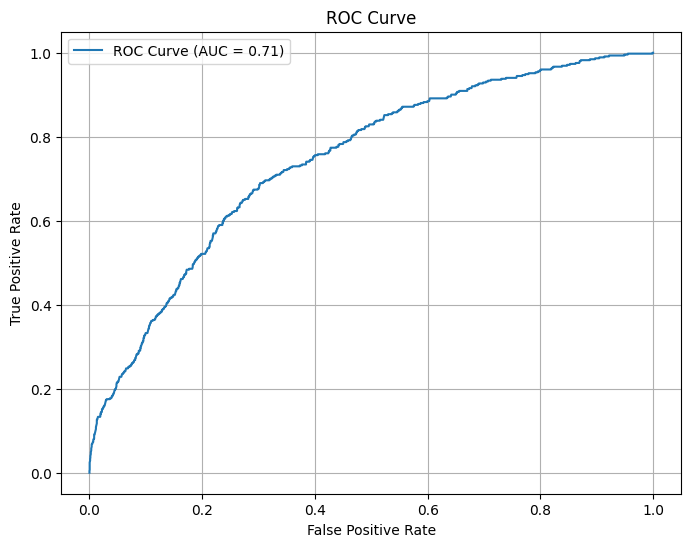

In [ ]:
# visualisation
roc_data = best_model.summary.roc.toPandas()

plt.figure(figsize=(8, 6))
plt.plot(roc_data['FPR'], roc_data['TPR'], label=f'ROC Curve (AUC = {auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.grid()
plt.show()